In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px

import networkx as nx
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count
import itertools

import seaborn as sns
from collections import Counter
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.cluster import SpectralClustering

### Load data

In [2]:
# Read emotion data
df_emo = pd.read_csv(
    'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
    sep='\t',
    header=None,
    names=['word', 'emotion', 'association'])

In [3]:
data = pd.read_csv('billboard_24years_lyrics_spotify_with_genres.csv')

print(f"Initial data shape: {data.shape}")

Initial data shape: (3080, 27)


In [4]:
print((data.drop_duplicates(subset='lyrics', keep='first')).shape[0])

2102


### New dataframe without duplicates based on lyrics

In [8]:
def aggregate_rows(group):
    # Combine unique categorical fields
    result = group.iloc[0].copy()
    result['band_singer'] = list(group['band_singer'].unique())
    result['url'] = list(group['url'].unique())
    result['songurl'] = list(group['songurl'].unique())
    
    # Average numeric fields
    numeric_cols = [
        'danceability','energy','key','loudness','mode','speechiness',
        'acousticness','instrumentalness','liveness','valence',
        'tempo','duration_ms'
    ]
    for col in numeric_cols:
        result[col] = group[col].mean()
    return result

data_single = (
    data
    .groupby('lyrics', as_index=False)
    .apply(aggregate_rows)
    .reset_index(drop=True)
)

print(data_single.shape[0])


2102


### Basic statistics

In [9]:
## Basic statistics of genres
df_genres = data_single[data_single['genre'].apply(bool)].reset_index(drop=True)

df_genres['genre'] = (
    df_genres['genre']
      .astype(str)
      .apply(lambda x: [g.strip() for g in x.split(',')] if ',' in x else [x.strip()]))

Number of songs with genres: 2102
Average number of genres per artist: 2.142245480494767
Total distinct genres: 329


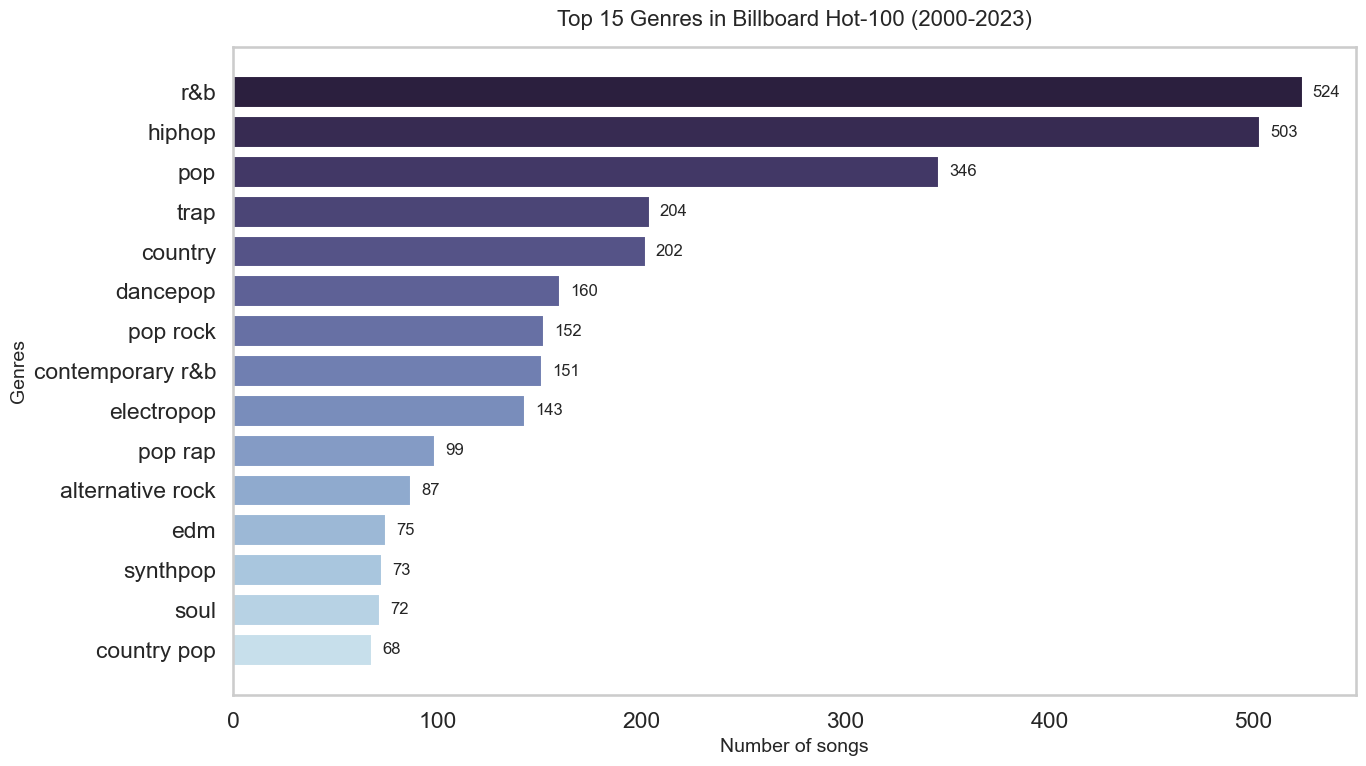

In [10]:
# --- Stats ---
num_artists_with_genres = len(df_genres)
avg_genres_per_artist = sum(len(genres) for genres in df_genres['genre']) / num_artists_with_genres
all_genres = [g for genres in df_genres['genre'] for g in genres]
num_distinct_genres = len(set(all_genres))
genre_counts = Counter(all_genres)

print("Number of songs with genres:", num_artists_with_genres)
print("Average number of genres per artist:", avg_genres_per_artist)
print("Total distinct genres:", num_distinct_genres)

# --- Top 15 genres ---
top = genre_counts.most_common(15)
names, counts = zip(*top)

# Reverse for horizontal bar chart
names = names[::-1]
counts = counts[::-1]

# Set Seaborn style
sns.set_style("whitegrid")
sns.set_context("talk")  # Larger font for reports

# Create figure
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(names, counts, color=sns.color_palette("ch:s=.25,rot=-.25", len(names)))

for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height()/2,
            f'{width}', va='center', fontsize=12)

# Titles and labels
ax.set_xlabel("Number of songs", fontsize=14)
ax.set_ylabel("Genres", fontsize=14)
ax.set_title("Top 15 Genres in Billboard Hot-100 (2000-2023)", fontsize=16, pad=15)

# remove grid
ax.grid(False)

# Clean layout
plt.tight_layout()
plt.show()


In [11]:
## Remove genres with less than 5 artists
filtered_genres = {genre for genre, count in genre_counts.items() if count >= 5}
df_genres['genre'] = df_genres['genre'].apply(lambda genres: [g for g in genres if g in filtered_genres])
df_genres = df_genres[df_genres['genre'].apply(bool)].reset_index(drop=True)

### Rettet hertil

________________________________________________________________________________________

### Map emotions to genre 

In [40]:
## Expand dataframe so each genre has its own row
df_expanded = df_genres.explode('genre').reset_index(drop=True)

In [41]:
## Function to map song lyrics to emotions and count frequency

def map_song_to_emotions_count(song_lyrics: str, word_to_emotions: dict) -> dict:
    """
    Map words in a song's lyrics to emotions and count frequency.
    Returns a dictionary: emotion -> count of words
    """
    words = song_lyrics.lower().split()
    emotion_counts = Counter()
    for word in words:
        if word in word_to_emotions:
            for emotion in word_to_emotions[word]:
                emotion_counts[emotion] += 1
    return dict(emotion_counts)

# --- Main execution ---
if __name__ == "__main__":
    # Step 1: Filter emotions with association == 1
    df_emo_ones = df_emo[df_emo['association'] == 1]

    # Step 2: Pre-build word -> emotion mapping
    word_to_emotions = defaultdict(list)
    for _, row in df_emo_ones.iterrows():
        word_to_emotions[row['word']].append(row['emotion'])

    # Step 3: Prepare song lyrics list
    songs_lyrics = df_expanded['lyrics'].tolist()

    # Step 4: Define worker for multiprocessing
    def worker_map_song(lyrics):
        return map_song_to_emotions_count(lyrics, word_to_emotions)

    # Step 5: Sequential processing (no parallelism)
    emotion_dicts = [worker_map_song(lyrics) for lyrics in songs_lyrics]

    # Step 6: Convert list of dicts to DataFrame and combine
    df_emotions = pd.DataFrame(emotion_dicts).fillna(0)
    df_songs_with_emotions = pd.concat([df_expanded.reset_index(drop=True), df_emotions.reset_index(drop=True)], axis=1)



In [42]:
## Find average emotion per genre
emotion_cols = ['anticipation','fear','joy','positive','trust',
                'anger','disgust','negative','sadness','surprise']

df_emotions_by_genre = (
    df_songs_with_emotions
        .groupby('genre')[emotion_cols]
        .mean()
        .reset_index()
)
df_emotions_by_genre[emotion_cols] = df_emotions_by_genre[emotion_cols].apply(pd.to_numeric, errors='coerce')
df_emotions_by_genre[emotion_cols] = df_emotions_by_genre[emotion_cols].fillna(0)

# # Most dominant emotion per genre
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre[emotion_cols].idxmax(axis=1)

In [43]:
## Expand to have column with positive/negative and a column with dominant emotion
def dominant_sentiment(row):
    if row['positive'] >= row['negative']:
        return 'positive'
    else:
        return 'negative'
    
def dominant_emotion(row):
    # Convert emotion columns to numeric
    numeric_vals = row[emotion_cols].astype(float)
    
    # Sort in descending order
    sorted_emotions = numeric_vals.sort_values(ascending=False)
    
    # Handle the case where positive/negative are at the top
    if sorted_emotions.index[0] in ['positive', 'negative']:
        if sorted_emotions.index[1] in ['positive', 'negative']:
            return sorted_emotions.index[2]
        return sorted_emotions.index[1]
    else:
        return sorted_emotions.index[0]



df_emotions_by_genre['sentiment'] = df_emotions_by_genre.apply(dominant_sentiment, axis=1)
df_emotions_by_genre['dominant_emotion'] = df_emotions_by_genre.apply(dominant_emotion, axis=1)

### Graph representation

Network with genres as nodes and links being the connecting songs having the same genres

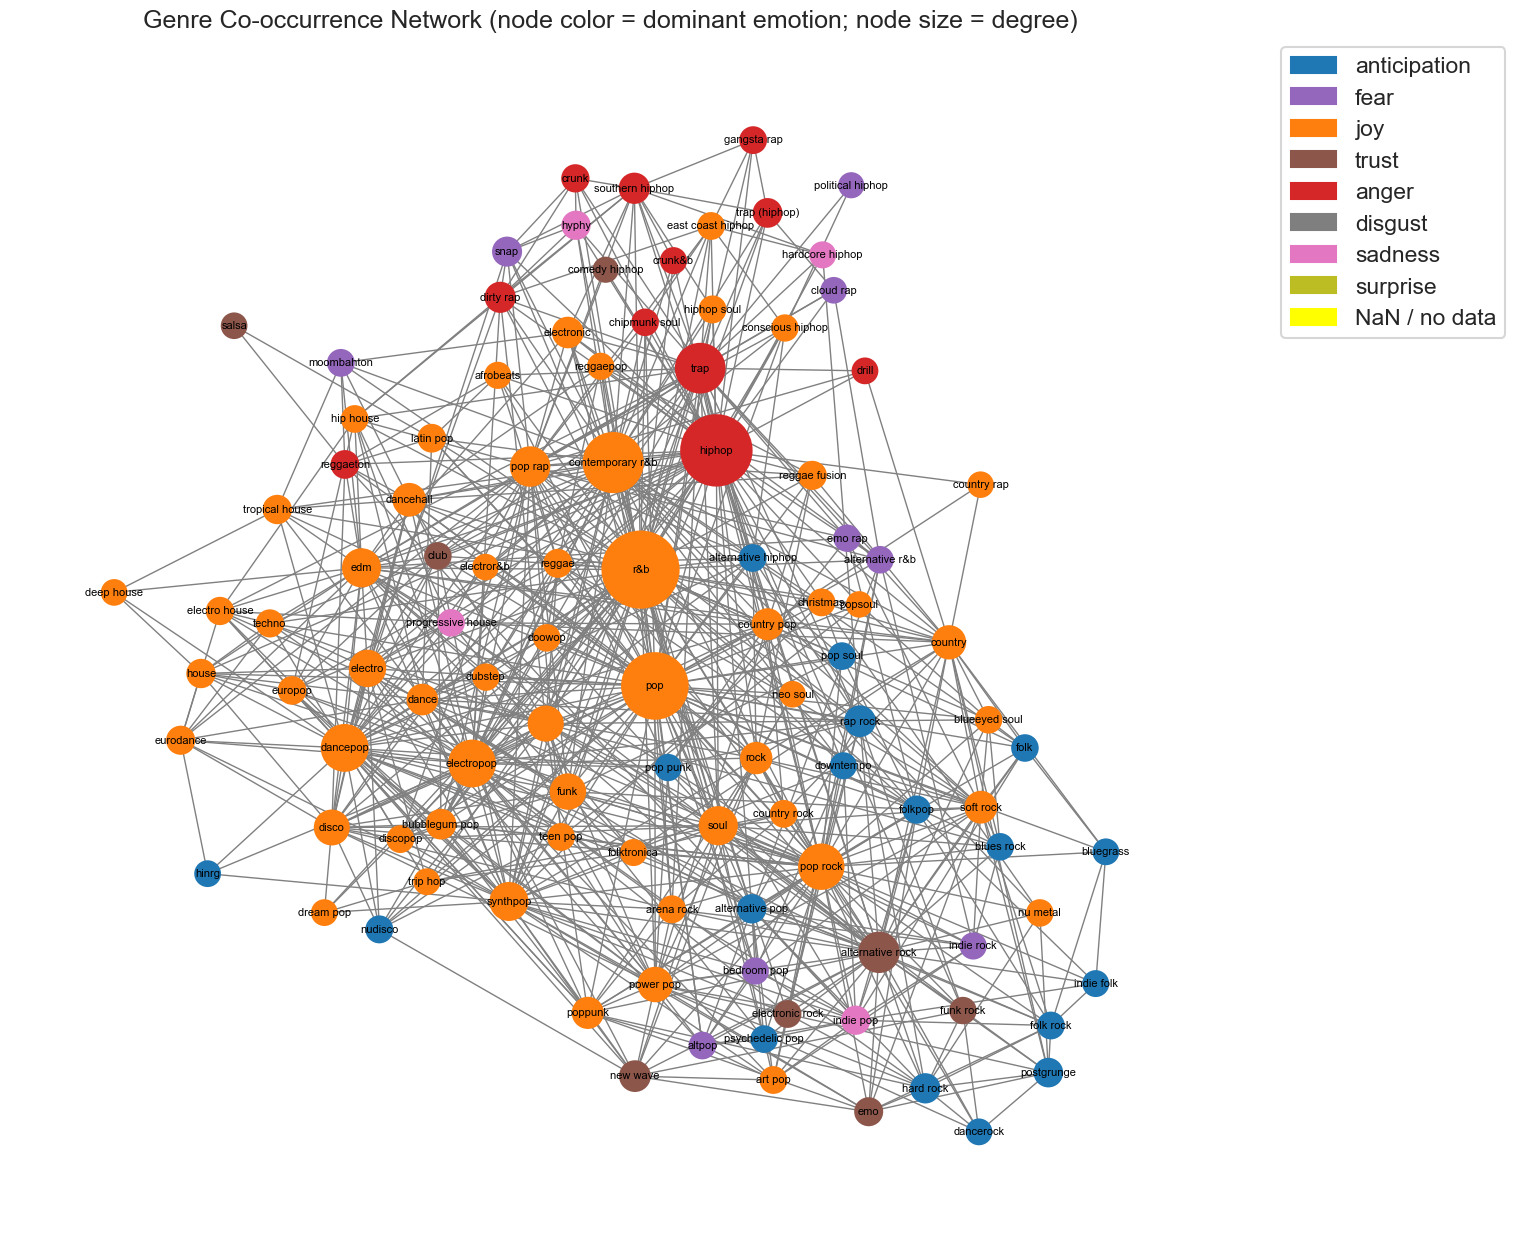

In [44]:
## Create graph with genres as nodes and links being the artist with both genres
G = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for genre1, genre2 in itertools.combinations(genres, 2):
            G.add_edge(genre1, genre2, weight=G.get_edge_data(genre1, genre2, {'weight': 0})['weight'] + 1)

G.remove_edges_from(nx.selfloop_edges(G))

# Map emotions to colors
emotion_color_map = {
    'anticipation': '#1f77b4', 
    'fear': '#9467bd', 
    'joy': '#ff7f0e',
    'trust': '#8c564b', 
    'anger': '#d62728', 
    'disgust': '#7f7f7f',
    'sadness': '#e377c2', 
    'surprise': '#bcbd22'
}

# Get node colors based on dominant emotion
node_colors = []
for node in G.nodes():
    dom = df_emotions_by_genre.loc[df_emotions_by_genre['genre'] == node, 'dominant_emotion']
    node_colors.append(emotion_color_map.get(dom.iloc[0], 'yellow') if not dom.empty and pd.notna(dom.iloc[0]) else 'yellow')

# Compute scaled node sizes from weighted degree
deg_vals = np.array([d for _, d in G.degree(weight='weight')])
node_sizes = (300 + (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min() + 1e-10) * 2700).tolist()

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G, max_iter=1000, seed=42)
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
        font_size=8, edge_color="gray")

patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color='yellow', label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Genre Co-occurrence Network (node color = dominant emotion; node size = degree)")
plt.show()

## Dominant positive/negative/neutral

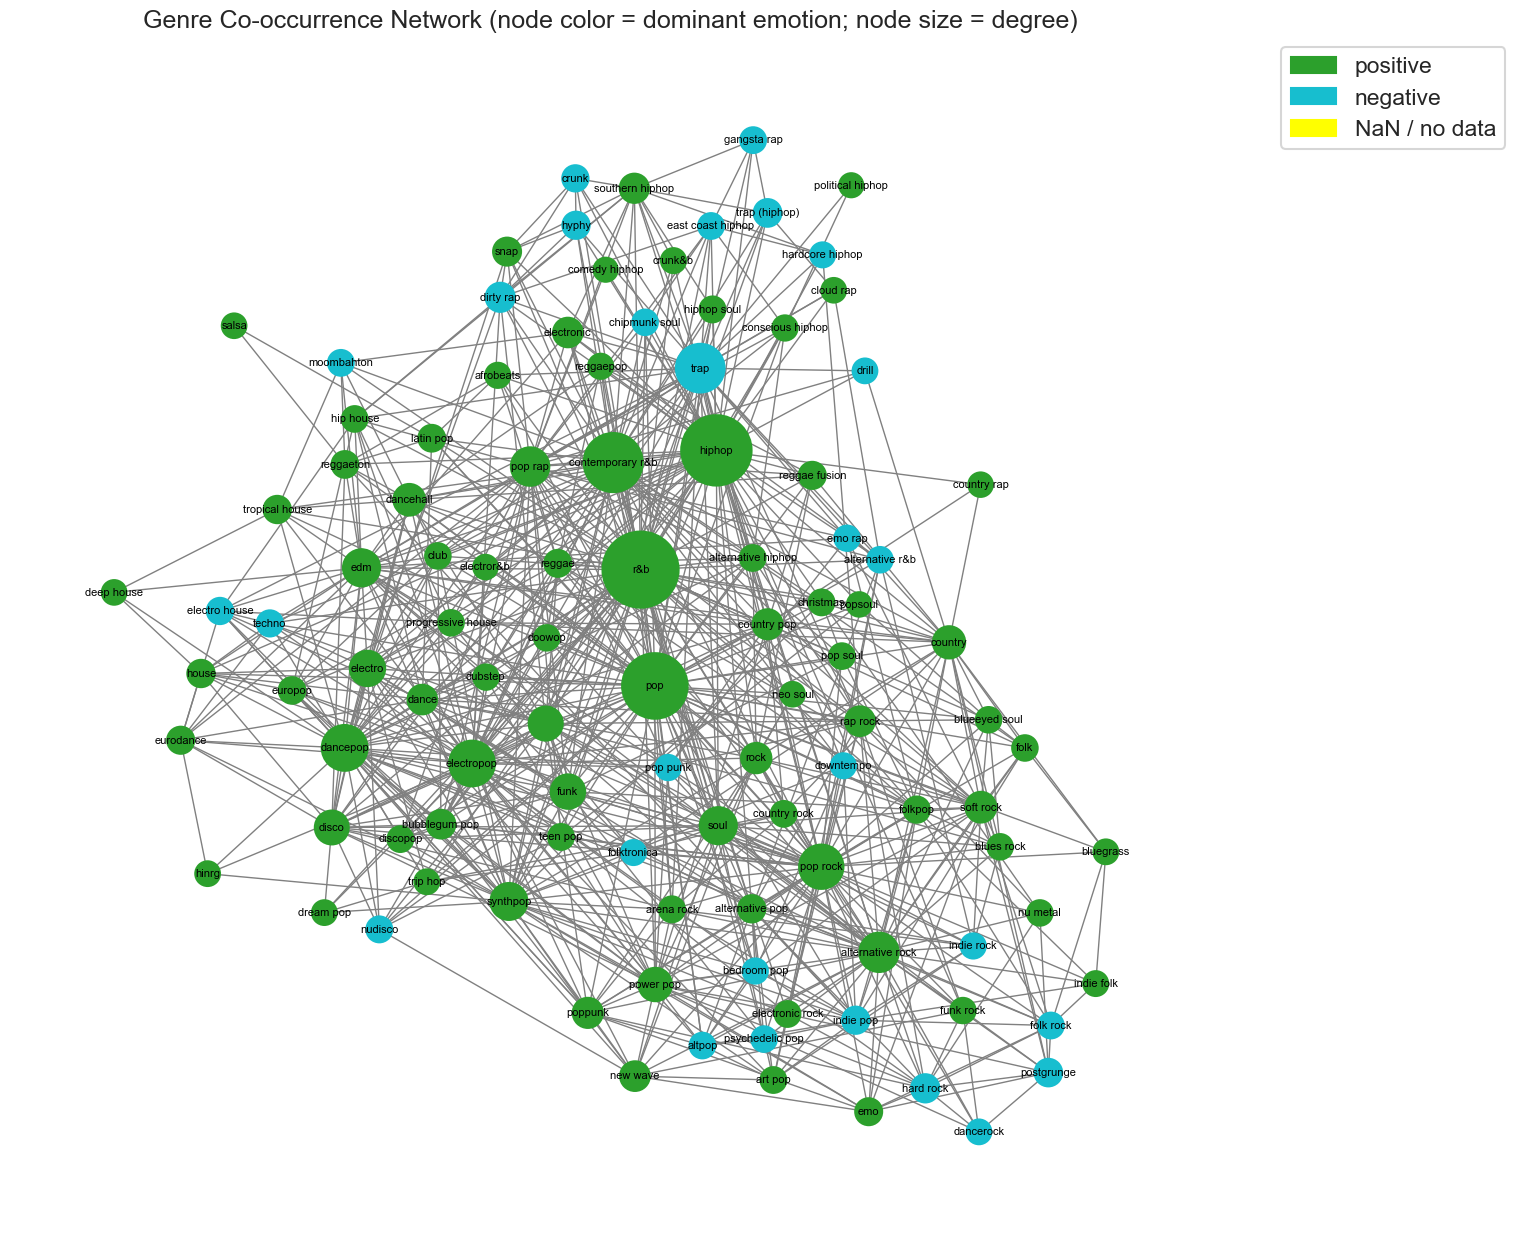

In [45]:
## Create graph with genres as nodes and links being the artist with both genres
G_ps = nx.Graph()
for genres in df_genres['genre']:
    if len(genres) > 1:
        for genre1, genre2 in itertools.combinations(genres, 2):
            G_ps.add_edge(genre1, genre2, weight=G_ps.get_edge_data(genre1, genre2, {'weight': 0})['weight'] + 1)

G_ps.remove_edges_from(nx.selfloop_edges(G_ps))

# Map emotions to colors
emotion_color_map = {
    'positive':     '#2ca02c',
    'negative':     '#17becf'
}

# Get node colors based on dominant emotion
node_colors = []
for node in G_ps.nodes():
    dom = df_emotions_by_genre.loc[df_emotions_by_genre['genre'] == node, 'sentiment']
    node_colors.append(emotion_color_map.get(dom.iloc[0], 'yellow') if not dom.empty and pd.notna(dom.iloc[0]) else 'yellow')

# Compute scaled node sizes from weighted degree
deg_vals = np.array([d for _, d in G_ps.degree(weight='weight')])
node_sizes = (300 + (deg_vals - deg_vals.min()) / (deg_vals.max() - deg_vals.min() + 1e-10) * 2700).tolist()

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(G_ps, max_iter=1000, seed=42)
nx.draw(G_ps, pos, with_labels=True, node_size=node_sizes, node_color=node_colors,
        font_size=8, edge_color="gray")

patches = [mpatches.Patch(color=c, label=e) for e, c in emotion_color_map.items()]
patches.append(mpatches.Patch(color='yellow', label='NaN / no data'))
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Genre Co-occurrence Network (node color = dominant emotion; node size = degree)")
plt.show()

!!! DEGREE DISTRIBUTION COMPARED TO RANDOM GRAPH !!!

In [46]:
# Get degrees of all nodes in the undirected graph
deg_dict = dict(G.degree())

# Turn to numpy array
degrees = np.fromiter(deg_dict.values(), dtype=int)

# Basic statistics
in_avg = degrees.mean()
in_median = np.median(degrees)
in_mode = pd.Series(degrees).mode()[0]
in_min = degrees.min()
in_max = degrees.max()

print("Degree Statistics:")
print(f"Average: {in_avg}")
print(f"Median: {in_median}")
print(f"Mode: {in_mode}")
print(f"Min: {in_min}")
print(f"Max: {in_max}")

# Degree counts
degree_counts = np.bincount(degrees)
x = np.arange(len(degree_counts))

# Random comparison distribution
np.random.seed(42)
random_counts = np.random.poisson(lam=max(1, in_avg), size=len(degree_counts))

# Plot
fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=degree_counts, name='Degree (Real)'))
fig.add_trace(go.Bar(x=x, y=random_counts, name='Degree (Random)',
                     opacity=0.6, visible='legendonly'))

# Mean and median lines
fig.add_vline(x=in_avg, line_dash="dash", line_color="green",
              annotation_text="Mean", annotation_position="top left")
fig.add_vline(x=in_median, line_dash="dot", line_color="red",
              annotation_text="Median", annotation_position="top right")

fig.update_layout(
    title="Degree Distribution (real vs random)",
    xaxis_title="Degree",
    yaxis_title="Count",
    bargap=0.2,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()


Degree Statistics:
Average: 14.429906542056075
Median: 10.0
Mode: 7
Min: 2
Max: 66


### What to include

__Betweenness centriality__ (fra social)

Measures how often a node lies on the shortest paths between others:

$$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$$

Nodes with high betweenness act as 'bridges' between different groups or genres.

In [47]:
## Betweenness centrality
betweenness = nx.betweenness_centrality(G)
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
print("Top 10 genres by betweenness centrality:")
for genre, centrality in sorted_betweenness[:10]:
    print(f"{genre}: {centrality:.4f}")

Top 10 genres by betweenness centrality:
r&b: 0.1422
hiphop: 0.1324
pop: 0.1119
pop rock: 0.0982
trap: 0.0513
contemporary r&b: 0.0506
electropop: 0.0460
dancepop: 0.0446
alternative rock: 0.0437
pop rap: 0.0345


The higher betweenness centrality, the more paths runs through the node/edge. It is more central.\
See that r&b have the highest betwenness centrality, but it is still quite low.

!!! ANDRE FORMER FOR CENTRALITY !!!

__Modularity__ (fra social)

For this we will use the measure **modularity** $M$ which is about looking into how the expected number of links between certain nodes (within a community) is compared to the actual number of links between those exact nodes. That is, if we for instance have a given degree sequence and the number of links between a chosen community of nodes is larger than expected, we would have positive modularity and hence a good "partitioning". 

In general, given a network with a community partioning, the higher the modularity, the better the partioning. On the other hand, the smaller the value of $M$ the worse the community structure. If we choose to maxmimize the modularity $M$ it would be equivalent to seeking the best community structure - the best partioning. 

(fra social)

We want to investigate different partionioning of communities using the genres to detect the partioning of the artists. Later on, we will use the Louvain-algorithm (LA) for the detection.

In order to evaulate the quality of the partioning, we use the modularity measure $M$ [1] (eq.12),

$$
M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right]
$$

where $L$ is the number of links in the network, $n_c$ is the number of communities, $L_c$ is the number of links in the community $c$ and $k_c$ is the total degree of all nodes within the community. 

To investigate the quality of the community partioning when using the first genre listed in each infobox, we decide to construct these communitites and calculate the modularity.

In [25]:
# Compute the best partition using Louvain Algorithm + Modularity
louvainC = nx.community.louvain_communities(G,seed=42) # NOTE I exercises bruges scikit pakke til Louvain

print(f"Detected {len(louvainC)} communities using Lovain algorithm.")

# Compute modularity
M_louvain = nx.community.modularity(G, louvainC)

L = G.number_of_edges()
M_LA = 0

for nodes in louvainC:
    subgraph = G.subgraph(nodes)
    Lc = subgraph.number_of_edges()
    kc = sum(dict(G.degree(nodes)).values())
    M_LA += (Lc / L) - (kc / (2*L))**2

print(f"Modularity computed from: {M_LA:.4f}")

Detected 6 communities using Lovain algorithm.
Modularity computed from: 0.2642


In [26]:
## Print the communities
for i, community in enumerate(louvainC):
    print(f"Community {i+1}: {community}")
    # Mean emotion per community
    comm_emotions = df_emotions_by_genre[df_emotions_by_genre['genre'].isin(community)]
    mean_emotions = comm_emotions[emotion_cols].mean().sort_values(ascending=False)
    print("Three most common emotions in community:")
    print(mean_emotions.head(3))
    print('\n')

Community 1: {'rockabilly', 'christmas', 'folk pop', 'pop soul'}
Three most common emotions in community:
positive        12.352139
anticipation     8.378610
joy              7.682888
dtype: float64


Community 2: {'salsa', 'latin pop', 'dance', 'miami bass', 'reggae fusion', 'cumbia', 'dancehall', 'reggaepop', 'reggaeton'}
Three most common emotions in community:
positive    13.003680
negative     9.649062
joy          8.114093
dtype: float64


Community 3: {'poppunk', 'altpop', 'emo', 'electronic rock', 'bluegrass', 'psychedelic pop', 'country pop', 'folk rock', 'alternative pop', 'alternative rock', 'orchestral pop', 'folk', 'nu metal', 'indie rock', 'rap rock', 'arena rock', 'indie pop', 'country rock', 'funk rock', 'indie folk', 'alternative r&b', 'folkpop', 'rock', 'country', 'art rock', 'pop rock', 'lofi', 'art pop', 'new wave', 'emo rap', 'country rap', 'cloud rap', 'hard rock', 'postgrunge', 'soft rock', 'power pop', 'blues rock', 'dancerock', 'bedroom pop', 'alternative hipho

Ser at positive og negative fylder meget. Derefter har community 2, 3, 5, 6 alle 'joy' som den emotion der ellers dominerer, hvor at anticipation dominerer i community 1 og anger i community 4. _Hvorfor?_ 

### Spectral clustering

In [ ]:
## Spectral clustering on the genre graph G

# Create adjacency matrix
adj_matrix = nx.to_numpy_array(G)
num_clusters = 5  # You can choose the number of clusters
spectral_model = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral_model.fit_predict(adj_matrix)
# Map genres to their cluster labels
genre_list = list(G.nodes())
genre_cluster_map = dict(zip(genre_list, labels))
# Print clusters and top 3 words in each cluster
for cluster_id in range(num_clusters):
    cluster_genres = [genre for genre, label in genre_cluster_map.items() if label == cluster_id]
    print(f"Cluster {cluster_id + 1}: {cluster_genres}")
    # Mean emotion per cluster
    cluster_emotions = df_emotions_by_genre[df_emotions_by_genre['genre'].isin(cluster_genres)]
    mean_emotions = cluster_emotions[emotion_cols].mean().sort_values(ascending=False)
    print("Three most common emotions in cluster:")
    print(mean_emotions.head(3))
    print('\n')

Cluster 1: ['tropical house', 'dancepop', 'electropop', 'edm', 'synthpop', 'synthwave', 'nudisco', 'moombahton', 'latin', 'electrohop', 'hip house', 'europop', 'progressive house', 'recession pop', 'future bass', 'technopop', 'house', 'folktronica', 'techno', 'deep house', 'eurodance', 'hinrg', 'electro house', 'pop punk', 'electrofunk', 'trance', 'dream pop', 'uk garage']
Three most common emotions in cluster:
positive    12.626191
joy          9.372701
negative     9.178139
dtype: float64


Cluster 2: ['folk', 'blueeyed soul', 'country pop', 'art pop', 'country', 'pop rock', 'new wave', 'psychedelic pop', 'soft rock', 'downtempo', 'arena rock', 'indie rock', 'indie pop', 'power pop', 'poppunk', 'rock', 'orchestral pop', 'country rock', 'folkpop', 'folk rock', 'bedroom pop', 'altpop', 'country rap', 'pop soul', 'trip hop', 'indie folk', 'art rock', 'alternative pop', 'blues rock', 'folk pop', 'lofi', 'bluegrass', 'christmas', 'rockabilly']
Three most common emotions in cluster:
positi